# Imports

In [1]:
import math
import pandas as pd
import numpy as np
import glob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from calendar import monthrange
pd.options.mode.chained_assignment = None

%matplotlib inline

# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [2]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### 1.1 Constants

In [3]:
DEFAULT_NAME_COLUMN_DATE = 'Date'
DEFAULT_NAME_COLUMN_DESCRIPTION = 'Description'
DEFAULT_NAME_COLUMN_TOTAL = 'Totals'
DEFAULT_NAME_COLUMN_COUNTRY = 'Country'

DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES = 'New cases'
DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS = 'New deaths'

DEFAULT_DATA_FORMAT = '%Y-%m-%d'

The definitions of the basic schema and formats for the given dataset are stored in the following dictionaries:

In [4]:
country_keys = ['guinea', 'liberia', 'sl']
paths = {x: DATA_FOLDER + '/ebola/'+ x + '_data' for x in country_keys}
countries = {'guinea': 'Guinea', 'liberia': 'Liberia', 'sl': 'Sierra Leone'}

wanted_columns = {'guinea': ['Date', 'Description', 'Totals'],
                      'liberia': ['Date', 'Variable', 'National'],
                      'sl': ['date', 'variable', 'National']}

date_original_formats = {'guinea': ['%Y-%m-%d', '%y-%m-%d'],
                         'liberia': ['%m/%d/%Y', '%m/%d/%y'],
                         'sl': ['%Y-%m-%d', '%y-%m-%d']}

### 1.2 Auxiliary functions

In [5]:
def sanitize_date(date, original_formats):
    '''
    Transform a string-type date - with a certain original
    format - into a string with the date in the default format.
    '''
    date_rep = None
    try:
        date_rep = datetime.datetime.strptime(date, original_formats[0])
    except ValueError:
        date_rep = datetime.datetime.strptime(date, original_formats[1])
    return date_rep.strftime(DEFAULT_DATA_FORMAT)

In [6]:
def estimate_daily_from_cum(np_list):
    '''
    Given a list of accumulated data, calculate the daily 
    'new' values, for deaths and cases.
    It assumes date-ordered data.
    '''
    last_known_n = -1
    final_list = list()
    for i, elem in np_list.iteritems():
        if (math.isnan(elem)):
            final_list.append(0)
        else:
            if (last_known_n == -1):
                final_list.append(0)
            else:
                final_list.append(elem - last_known_n)
            last_known_n = elem
    return np.array(final_list)

### 1.3 Read files

We create a dictionary `dataframe_dict` that contains, for each country, the corresponding dataframe.

After reading each dataframe we apply the function `sanitize_date` to the `Date` column - to make sure that the format used for the date is consistent - and we then sort the rows in each dataframe according to it.

In [7]:
dataframe_dict = {}

for i in country_keys:
    temp_list = []
    all_files = glob.glob(paths[i] + '/*.csv')
    for file in all_files:
        temp_df = pd.read_csv(file)
        temp_list.append(temp_df)
    dataframe_dict[i] = pd.concat(temp_list)
    
    # Format dates and order dataframes by date
    dataframe_dict[i][wanted_columns[i][0]] = np.array([sanitize_date(x, date_original_formats[i])
                                                        for x in dataframe_dict[i][wanted_columns[i][0]]])
    
    dataframe_dict[i][wanted_columns[i][0]] = pd.to_datetime(dataframe_dict[i][wanted_columns[i][0]])
    dataframe_dict[i].sort_values(by=wanted_columns[i][0])

### 1.4 Parsing data for each country

The goal of the parsing auxiliary functions is to obtain a *standard* datataset for each country. We want to extract the useful data for our task while reorganizing the schema and data format to develop a general coherence.

In particular, we want to obtain the daily number of `new deaths` and `new cases` registered for each country.

***N.B.*** The resulting dataframes do not have the indexing reformatted. Since they will later be concatenated in a single dataframe and reset all-together, we decided that this intermediate indexing would be unnecessary.

#### 1.4.1 Guinea

In order to parse the Guinea dataset we considered the variables ```New deaths registered``` (or ```New deaths registered today``` when it was used instead of the previous one) and ```Total new cases registered so far```. These variables represent the daily number of deaths and cases respectively.

In [8]:
# Select certain column from the CSV formatted files
parsed_guinea_df = dataframe_dict['guinea'][wanted_columns['guinea']]
guinea_wanted_row_list = ['Total new cases registered so far',
                          'New deaths registered',
                          'New deaths registered today']

# Select all the rows that match desired names for 'Description' column
parsed_guinea_df = parsed_guinea_df[parsed_guinea_df['Description'].isin(guinea_wanted_row_list)]

# Rename every row value for 'Description' column 
parsed_guinea_df.loc[parsed_guinea_df['Description'] ==
                     guinea_wanted_row_list[0], 'Description'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES

parsed_guinea_df.loc[parsed_guinea_df['Description'] ==
                     guinea_wanted_row_list[1], 'Description'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS

parsed_guinea_df.loc[parsed_guinea_df['Description'] ==
                     guinea_wanted_row_list[2], 'Description'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS

# Add 'Country' column to dataframe
parsed_guinea_df[DEFAULT_NAME_COLUMN_COUNTRY] = countries['guinea']

Sample:

In [9]:
parsed_guinea_df.head()

,Date,Description,Totals,Country
3,2014-08-04,New cases,9,Guinea
8,2014-08-04,New deaths,2,Guinea
3,2014-08-26,New cases,28,Guinea
9,2014-08-26,New deaths,5,Guinea
3,2014-08-27,New cases,22,Guinea


#### 1.4.2 Liberia

In order to parse the Liberia dataset we considered the `Newly reported deaths` variable, which represents the daily number of deaths. On the other hand, to handle the new cases data we had to do some manipulations. 

The number of new (daily) cases comes in three different variables:
* `New Case/s (Suspected)`
* `New Case/s (Probable)`
* `New Case/s (confirmed)` 

These have to be summed up to obtain the total value of new cases.

In [10]:
# Select certain columns from the CSV formatted files
liberia_df = dataframe_dict['liberia'][wanted_columns['liberia']]

liberia_wanted_row_list = ['New Case/s (Suspected)',
                   'New Case/s (Probable)',
                   'New case/s (confirmed)',
                   'Newly reported deaths',
                   'Total suspected cases',
                   'Total probable cases',
                   'Total confirmed cases']

However, the data comes with strangely big new cases values for the last days of the report:

In [11]:
liberia_df[(liberia_df['Variable'] == 'New case/s (confirmed)') &
           (liberia_df['Date'].apply(lambda x: x.month) == 12)].sort_values(by=['Date'])

,Date,Variable,National
25,2014-12-01,New case/s (confirmed),1.0
25,2014-12-02,New case/s (confirmed),9.0
25,2014-12-03,New case/s (confirmed),NaN
25,2014-12-04,New case/s (confirmed),2867.0
25,2014-12-05,New case/s (confirmed),2867.0
25,2014-12-06,New case/s (confirmed),2869.0
25,2014-12-07,New case/s (confirmed),2869.0
25,2014-12-08,New case/s (confirmed),2927.0
25,2014-12-09,New case/s (confirmed),2946.0


We concluded that those numbers couldn't be correct. As we found a correlation between those values and the total new cases accumulator for the past days, we assumed the data as been inputted on the wrong part of the table.

The new cases data for the last month of the report were therefore calculated from the daily difference of the cases accumulators, while we took the daily values for the rest of the months.

In [12]:
# Create temporary dataframes for new case entries
# Take accumulated cases for the last month of the report (before the 4th, exclusively)
liberia_df_cum_cases_1 = liberia_df[liberia_df['Variable'].isin(liberia_wanted_row_list[4:7])]
liberia_df_cum_cases_1 = liberia_df_cum_cases_1[liberia_df_cum_cases_1['Date'].map(
    lambda x: x.month == 12 and x.day <= 3)]
liberia_df_cum_cases_1 = liberia_df_cum_cases_1.groupby('Date').sum()

# Take accumulated cases for the last month of the report (after the 4th, inclusively)
liberia_df_cum_cases_2 = liberia_df[liberia_df['Variable'].isin(liberia_wanted_row_list[0:3])]
liberia_df_cum_cases_2 = liberia_df_cum_cases_2[liberia_df_cum_cases_2['Date'].map(
    lambda x: x.month == 12 and x.day > 3)]
liberia_df_cum_cases_2 = liberia_df_cum_cases_2.groupby('Date').sum()

liberia_df_cum_cases = pd.concat([liberia_df_cum_cases_1, liberia_df_cum_cases_2])
liberia_df_cum_cases['National'] = estimate_daily_from_cum(liberia_df_cum_cases['National'])

# Take daily cases for the other months
liberia_df_new_cases = liberia_df[liberia_df['Variable'].isin(liberia_wanted_row_list[0:3])]
liberia_df_new_cases = liberia_df_new_cases[liberia_df_new_cases['Date'].map(
    lambda x: x.month != 12)]

# Get dataframe with new cases for all months
liberia_df_new_cases = pd.concat([liberia_df_new_cases, liberia_df_cum_cases])

# Sum all of the values for 'Probable', 'Variable' and 'Confirmed' new cases
liberia_df_new_cases = liberia_df_new_cases.groupby('Date').sum()

liberia_df_new_cases['Date'] = liberia_df_new_cases.index
liberia_df_new_cases['Variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES

In [13]:
# Create temporary dataframe for new deaths entries
liberia_df_new_deaths = liberia_df[liberia_df['Variable'] == liberia_wanted_row_list[3]]
liberia_df_new_deaths['Variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS

In [14]:
# Create dataframe with new deaths and cases (concatenating the two temporary)
parsed_liberia_df = pd.concat([liberia_df_new_cases, liberia_df_new_deaths])

parsed_liberia_df.rename(columns={'Date': DEFAULT_NAME_COLUMN_DATE,
                                  'Variable': DEFAULT_NAME_COLUMN_DESCRIPTION,
                                  'National': DEFAULT_NAME_COLUMN_TOTAL}, inplace=True)

# Add 'Country' column to dataframe
parsed_liberia_df[DEFAULT_NAME_COLUMN_COUNTRY] = countries['liberia']

Sample:

In [15]:
parsed_liberia_df.head()

,Date,Totals,Description,Country
2014-06-16 00:00:00,2014-06-16,4.0,New cases,Liberia
2014-06-17 00:00:00,2014-06-17,2.0,New cases,Liberia
2014-06-22 00:00:00,2014-06-22,10.0,New cases,Liberia
2014-06-24 00:00:00,2014-06-24,6.0,New cases,Liberia
2014-06-25 00:00:00,2014-06-25,7.0,New cases,Liberia


#### 1.4.3 Sierra Leone

In order to parse the Sierra Leone dataset we followed similar steps as for Liberia. The new cases value has been computed as the sum of the corresponding variables of the table:
* `new_noncase`
* `new_suspected`
* `new_probable`
* `new_confirmed` 

Since the dataset only had total accumulators for the number of deaths, the new death variable was calculated as the difference between days, as previously done with Liberia. The possible missing data for this operation has been handled by setting them to zero, while keeping the the same delta for known points. An alternative to this would be to do a linear interpolation between the two accumulator values we knew (to fill in the missing data), but it wouldn't make a difference for the final daily-average result.

In [16]:
# Select certain columns from the CSV formatted files
parsed_sierra_df = dataframe_dict['sl'][wanted_columns['sl']]

sierra_wanted_row_list = ['new_noncase', 'new_suspected', 'new_probable', 'new_confirmed',
                   'death_confirmed', 'death_probable', 'death_suspected']

In [17]:
# Create temporary dataframe for new case entries
# (with every row that matches the desired 'variables' column value)
sierra_df_new_cases = parsed_sierra_df[parsed_sierra_df['variable'].isin(
    sierra_wanted_row_list[0:4])]

# Sum all of the values for 'Probable', 'Suspected', 'Confirmed' and 'Noncase' new cases
sierra_df_new_cases = sierra_df_new_cases.groupby('date')['National'].apply(
    lambda x: np.array([float(y) for y in x]).sum()).to_frame()

sierra_df_new_cases['date'] = sierra_df_new_cases.index
sierra_df_new_cases['variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES

In [18]:
# Create temporary dataframe for new deaths' accumulator entries
sierra_df_new_deaths_cum = parsed_sierra_df[parsed_sierra_df['variable'].isin(
    sierra_wanted_row_list[4:7])]

# Sum all of the values for 'Probable', 'Suspected' and 'Confirmed' new death accumulators
sierra_df_new_deaths_cum = sierra_df_new_deaths_cum.groupby('date')['National'].apply(
    lambda x: np.array([float(y) for y in x]).sum()).to_frame()

sierra_df_new_deaths_cum['date'] = sierra_df_new_deaths_cum.index
sierra_df_new_deaths_cum['variable'] = 'New deaths accumulator'

# Compute daily values
sierra_df_new_deaths_cum['National'] = estimate_daily_from_cum(sierra_df_new_deaths_cum['National'])
sierra_df_new_deaths_cum['variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS

In [19]:
# Concatenate both 'new cases' and 'new deaths' temporary dataframes
parsed_sierra_df = pd.concat([sierra_df_new_cases, sierra_df_new_deaths_cum])

parsed_sierra_df.rename(columns={'date': DEFAULT_NAME_COLUMN_DATE,
                                 'variable': DEFAULT_NAME_COLUMN_DESCRIPTION,
                                 'National': DEFAULT_NAME_COLUMN_TOTAL}, inplace=True)

# Add 'Country' column to dataframe
parsed_sierra_df[DEFAULT_NAME_COLUMN_COUNTRY] = countries['sl']

Sample:

In [20]:
parsed_sierra_df.head()

,Totals,Date,Description,Country
date,,,,
2014-08-12,26.0,2014-08-12,New cases,Sierra Leone
2014-08-13,32.0,2014-08-13,New cases,Sierra Leone
2014-08-14,41.0,2014-08-14,New cases,Sierra Leone
2014-08-15,32.0,2014-08-15,New cases,Sierra Leone
2014-08-16,30.0,2014-08-16,New cases,Sierra Leone


### 1.5 Joining the parsed country datatset into a single one

In [21]:
complete_df = pd.concat([parsed_guinea_df, parsed_liberia_df, parsed_sierra_df])
complete_df.reset_index(inplace=True, drop=True)

Samples:

In [22]:
complete_df[42:47]

,Country,Date,Description,Totals
42,Guinea,2014-10-01,New cases,34
43,Guinea,2014-10-01,New deaths,15
44,Liberia,2014-06-16,New cases,4
45,Liberia,2014-06-17,New cases,2
46,Liberia,2014-06-22,New cases,10


Even after handling the NaN troubles during the parsing for some aspects, we still have some to manage

In [23]:
complete_df[complete_df[DEFAULT_NAME_COLUMN_TOTAL].isnull()].head()

,Country,Date,Description,Totals
178,Liberia,2014-09-20,New deaths,NaN
223,Liberia,2014-11-28,New deaths,NaN
225,Liberia,2014-11-30,New deaths,NaN
226,Liberia,2014-12-01,New deaths,NaN
227,Liberia,2014-12-02,New deaths,NaN


Since this is missing information, from now on we assume that the missing values are 0

In [24]:
complete_df = complete_df.fillna(0)

At this point, we noticed that there were negative values for the daily estimated measurements. This was probably due to an error when keeping track of the accumulated number of deaths/cases, which became apparent on the months transition. Even though we might be neglecting some measurements, we decided that normalizing these values to 0 (on the first day of the following month) would prevent error-propagation to our averages calculation.

Below is an example of such case:

In [25]:
complete_df[complete_df['Totals'].apply(lambda x: int(x)) < 0]

,Country,Date,Description,Totals
387,Sierra Leone,2014-10-01,New deaths,-18


In [26]:
complete_df.loc[complete_df['Totals'].apply(lambda x: int(x)) < 0, 'Totals'] = 0

### 1.6 Calculate, for each country, the daily average per month of new cases and deaths

We start grouping by ```Country```, ```Description``` and month, and then calculate the average over the total number of days in the month.

In [27]:
grouped = complete_df.groupby(by=[complete_df.Country, complete_df.Description,
                                  [x.month for x in complete_df.Date]])

We create a dataframe with the averaged new deaths/cases, from the aggregated `grouped` elements. To note that this average is calculated over the days in a specific month (not as an averaged 30-day period nor by the number of samples).

In [28]:
calculated_average_df = pd.DataFrame()

for ((country, description, month), values) in grouped:
    days_in_month = monthrange(2014, month)[1]
    entry = {DEFAULT_NAME_COLUMN_COUNTRY: country, 
             'Description': description, 
             'Month': month, 
             'Average': values[DEFAULT_NAME_COLUMN_TOTAL].apply(lambda x: float(x) / days_in_month).sum()}
    calculated_average_df = calculated_average_df.append([entry])

Sample:

In [29]:
calculated_average_df.head()

,Average,Country,Description,Month
0,4.161290,Guinea,New cases,8
0,10.466667,Guinea,New cases,9
0,1.096774,Guinea,New cases,10
0,0.548387,Guinea,New deaths,8
0,1.900000,Guinea,New deaths,9


For the following step we created a transformed dataframe with a more practical schema. Instead of having a `Description` column - with `New cases` and `New deaths` - we would like have one column for each of its values.

In [30]:
death_average_df = calculated_average_df[calculated_average_df[DEFAULT_NAME_COLUMN_DESCRIPTION] ==
                                         DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS]
cases_average_df = calculated_average_df[calculated_average_df[DEFAULT_NAME_COLUMN_DESCRIPTION] ==
                                         DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES]

calculated_average_df = pd.merge(death_average_df, cases_average_df, on=[DEFAULT_NAME_COLUMN_COUNTRY, 'Month'])
calculated_average_df.drop([DEFAULT_NAME_COLUMN_DESCRIPTION+'_x',
                            DEFAULT_NAME_COLUMN_DESCRIPTION+'_y'], axis=1, inplace=True)

calculated_average_df = calculated_average_df.rename(columns={'Average_x': 'Death monthly average',
                                                              'Average_y': 'Case monthly average'})

Sample:

In [31]:
calculated_average_df.head()

,Death monthly average,Country,Month,Case monthly average
0,0.548387,Guinea,8,4.161290
1,1.900000,Guinea,9,10.466667
2,0.483871,Guinea,10,1.096774
3,0.466667,Liberia,6,1.333333
4,1.516129,Liberia,7,3.032258


After reordering the columns, the final result is shown in the following table:

In [32]:
calculated_average_df = calculated_average_df[['Country', 'Month',
                                               'Death monthly average', 'Case monthly average']]
calculated_average_df.head()

,Country,Month,Death monthly average,Case monthly average
0,Guinea,8,0.548387,4.161290
1,Guinea,9,1.900000,10.466667
2,Guinea,10,0.483871,1.096774
3,Liberia,6,0.466667,1.333333
4,Liberia,7,1.516129,3.032258


### 1.7 Plots

We plotted the results for a final visualisation of the obtained data. First by `Country` alone in the following bar charts:

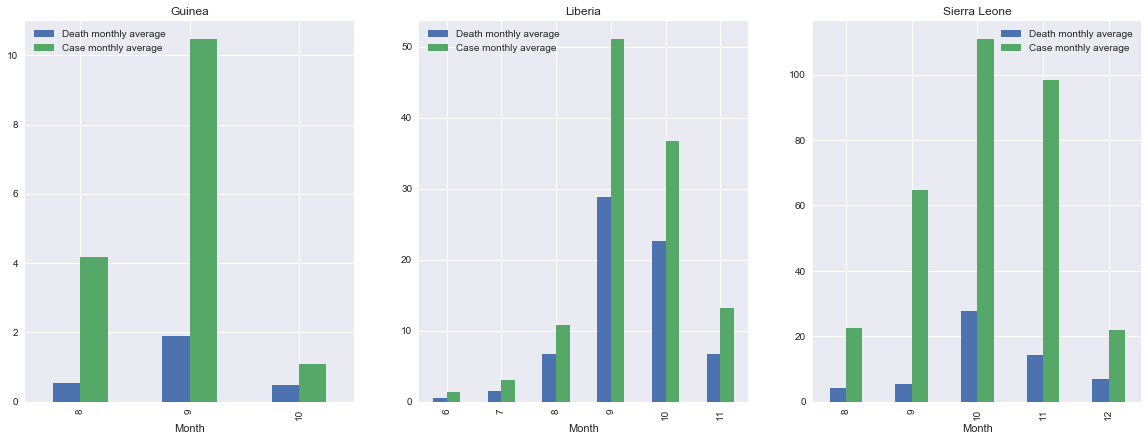

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

for i, (title, group) in enumerate(calculated_average_df.groupby(DEFAULT_NAME_COLUMN_COUNTRY)):
    group.plot.bar(x='Month', title=title, ax=axes.flat[i])

And lastly as an unique bar chart for all the results in one plot

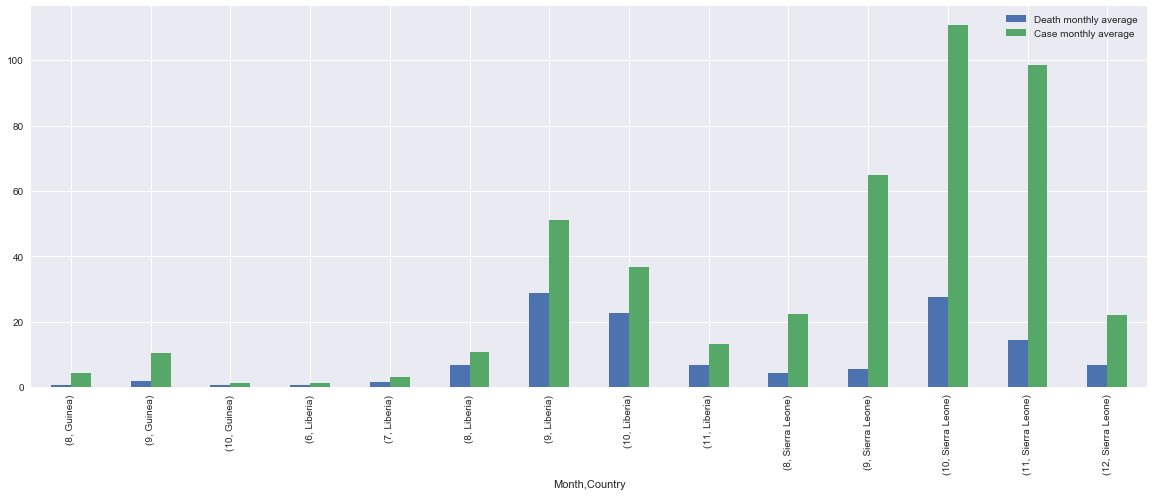

In [34]:
calculated_average_df.plot.bar(x=['Month',DEFAULT_NAME_COLUMN_COUNTRY], figsize=(20,7))

# Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

### 2.1 Read files

We started by importing the nine tables in one single big dataframe

In [35]:
all_files = glob.glob(DATA_FOLDER + '/microbiome' + '/MID*.xls')
raw_df = pd.DataFrame()

for file in all_files:
    file_name = file[file.rfind('MID'):file.rfind('.')]
    temp_df = pd.read_excel(file, header=None)
    temp_df['BARCODE'] = file_name
    raw_df = raw_df.append(temp_df)

Sample:

In [36]:
raw_df.head()

,0,1,BARCODE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,MID1
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID1
2,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,MID1
3,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,MID1
4,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,MID1


We then imported the metadata table in another dataframe:

In [37]:
metadata_df = pd.read_excel(DATA_FOLDER+'/microbiome'+'/metadata.xls')
metadata_df

,BARCODE,GROUP,SAMPLE
0,MID1,EXTRACTION CONTROL,NaN
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue
5,MID6,NEC 1,stool
6,MID7,Control 1,stool
7,MID8,NEC 2,stool
8,MID9,Control 2,stool


### 2.2 Merging the dataframes

The final goal is to obtain a single dataframe for the given data. We will need to obtain a table with the following schema:

| Description | Group | Tissue | Stool | Other |
|-------------|-------|--------|-------|-------|
|             |       |        |       |       |
|             |       |        |       |       |
|             |       |        |       |       |


We will fill-in the last three columns with the sample data we have in the initial dataframe. The column will be chosen according to what the metadata provides. The same idea will be followed to fill-in the Group column with the correct information

We create three dataframes containing the metadata information, one for a each `Sample` type

In [38]:
stool_metadata_df = metadata_df[metadata_df['SAMPLE'] == 'stool']
tissue_metadata_df = metadata_df[metadata_df['SAMPLE'] == 'tissue']
na_metadata_df = metadata_df[metadata_df['SAMPLE'].isnull()]

Sample:

In [39]:
tissue_metadata_df

,BARCODE,GROUP,SAMPLE
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue


We create three dataframes for the different samples according to what we have in the metatada dataframes obtained before

In [40]:
raw_df = pd.merge(raw_df, metadata_df[['BARCODE', 'GROUP']], on=['BARCODE'])
raw_df.rename(columns={0: 'Description', 1: 'Sample'}, inplace=True)

stool_df = raw_df[raw_df['BARCODE'].isin(list(stool_metadata_df['BARCODE']))].drop('BARCODE', axis=1)
stool_df.rename(columns={'Sample': 'Stool'}, inplace=True)
              
tissue_df = raw_df[raw_df['BARCODE'].isin(list(tissue_metadata_df['BARCODE']))].drop('BARCODE', axis=1)
tissue_df.rename(columns={'Sample': 'Tissue'}, inplace=True)
              
na_df = raw_df[raw_df['BARCODE'].isin(list(na_metadata_df['BARCODE']))].drop('BARCODE', axis=1)
na_df.rename(columns={'Sample': 'Other'}, inplace=True)

Sample:

In [41]:
stool_df.head()

,Description,Stool,GROUP
1440,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,NEC 1
1441,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,NEC 1
1442,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,NEC 1
1443,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,NEC 1
1444,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",5,NEC 1


We merge those three temporary dataframes into a single one:

In [42]:
merged_df = pd.merge(stool_df, tissue_df, how='outer', on=['Description', 'GROUP'])
merged_df = pd.merge(merged_df, na_df, how='outer', on=['Description', 'GROUP'])
merged_df.head()

,Description,Stool,GROUP,Tissue,Other
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7.0,NEC 1,23.0,NaN
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1.0,NEC 1,1.0,NaN
2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1.0,NEC 1,NaN,NaN
3,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2.0,NEC 1,2.0,NaN
4,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",5.0,NEC 1,10.0,NaN


To complete the task, we fill the NaN values of the dataset with the 'unknown' value and we rename columns according to the desired schema:

In [43]:
# Fill of the 'unknown' value for NaNs
merged_df.fillna('unknown', inplace=True)

# Final cleaning up of the table schema
merged_df.rename(columns={'GROUP':'Group'}, inplace=True)

merged_df.head()

,Description,Stool,Group,Tissue,Other
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,NEC 1,23,unknown
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,NEC 1,1,unknown
2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,NEC 1,unknown,unknown
3,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,NEC 1,2,unknown
4,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",5,NEC 1,10,unknown


Lastly we create a unique index based on `Group` and `Description`. For the merged dataframe, these two columns give us an unique index if:
* In the metadata, for each unique pair of `Sample` and `Group`, the `Description` values are unique

In [44]:
merged_df = merged_df.set_index(['Description', 'Group'])
merged_df

,,Stool,Tissue,Other
Description,Group,,,
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",NEC 1,7,23,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",NEC 1,1,1,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrodictium",NEC 1,1,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus",NEC 1,2,2,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus",NEC 1,5,10,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Sulfurisphaera",NEC 1,4,11,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Thermoproteales Thermofilaceae Thermofilum",NEC 1,4,9,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Thermoproteales Thermoproteaceae Caldivirga",NEC 1,1,5,unknown
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanocellales Methanocellaceae Methanocella",NEC 1,12,9,unknown


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [45]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


### 3.0 Read files

We start by reading the Titanic data Excel file

In [46]:
titanic_df = pd.read_excel(DATA_FOLDER+'/titanic.xls')
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


We then read the HTML file that contains the metadata.

In [47]:
metadata_df = pd.read_html(DATA_FOLDER+'/titanic.html', header=0)

As we saw previously when the metadata was displayed, the second table contains the level for some of the categorical variables. However, the first column only contains the name of the variable for its first level. We fix this by filling in the first column with the corresponding names of variables:

In [48]:
# Fills the null values, in the first column, with the last non-null value
metadata_df[1]['Variable'].fillna(method='ffill', inplace=True)
metadata_df[1].head()

,Variable,Levels
0,pclass,1st
1,pclass,2nd
2,pclass,3rd
3,sex,female
4,sex,male


We have seen that some passengers have several cabins assigned. In these cases we are assuming that the first of the cabins was the one they travelled in. There are also some cabins with the formats ```F Gxx``` and ```F Exx```. For these we will assume that the cabins were in **Deck F**.

In [49]:
titanic_df['cabin'] = titanic_df['cabin'].apply(
    lambda x: None if not x else str(x).split()[0])

Sample:

In [50]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### 3.1 Description of attributes
Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`.

#### 3.1.1 Non-categorical attributes

* name: string
* age: real number; If it's less than 1 then the passenger was younger than 1 year old. If it's in the form xx.5 then the age is an estimation; (null values possible)
* sibsp: integer
* parch: integer
* fare: real number (null values possible)
* body: integer (null values possible)
* home.dest: string (null values possible)

The non-categorical attributes are the following:

In [51]:
non_categorical_attributes = ['name', 'age', 'sibsp', 'parch', 'fare', 'body', 'home.dest']

In [52]:
for attribute in non_categorical_attributes:
    print(attribute)
    print('Type: ' + str(type(titanic_df[attribute][0])))
    if not isinstance(titanic_df[attribute][0], str):
        print('Range: ' + str(titanic_df[attribute].min()) + '-' + str(titanic_df[attribute].max()))
    print()

name
Type: <class 'str'>

age
Type: <class 'numpy.float64'>
Range: 0.1667-80.0

sibsp
Type: <class 'numpy.int64'>
Range: 0-8

parch
Type: <class 'numpy.int64'>
Range: 0-9

fare
Type: <class 'numpy.float64'>
Range: 0.0-512.3292

body
Type: <class 'numpy.float64'>
Range: 1.0-328.0

home.dest
Type: <class 'str'>



#### 3.1.2 Categorical Attributes

The attributes that are included in ```metadata_df[1]``` are Categorical, and the possible values that each attribute can take (*levels*) are included in  ```metadata_df[1]``` as well. However, we will consider only the values that are possible after our assumptions. We are also considering ```unknown``` or ```NaN``` as a possible value for the attributes that can have null values.

We can also consider the ```survival``` attribute to be Categorical, since it can only take the values 0 or 1 depending on whether the person survived or not.

We assumed that all the information for the tickets is important, and that we should consider this attribute to be a string. Then, the last categorical attribute that we can consider is the ```ticket```, since the ticket ID is a non unique string.

In [53]:
titanic_df['ticket'] = titanic_df['ticket'].map(lambda x: str(x))
titanic_df['boat'] = titanic_df['boat'].map(lambda x: str(x))

In [54]:
categorical_attributes = ['survived', 'ticket']
for attribute in list(metadata_df[1]['Variable'].unique()) + categorical_attributes:
    print('Attribute: '+attribute)
    print('Type: '+str(type(titanic_df[attribute][0])))
    if attribute in ['cabin', 'ticket']:
        print(str(len(titanic_df[attribute].unique()))+ ' levels')
    else:
        print(titanic_df[attribute].unique())
    print()

Attribute: pclass
Type: <class 'numpy.int64'>
[1 2 3]

Attribute: sex
Type: <class 'str'>
['female' 'male']

Attribute: cabin
Type: <class 'str'>
182 levels

Attribute: embarked
Type: <class 'str'>
['S' 'C' nan 'Q']

Attribute: boat
Type: <class 'str'>
['2' '11' 'nan' '3' '10' 'D' '4' '9' '6' 'B' '8' 'A' '5' '7' 'C' '14' '5 9'
 '13' '1' '15' '5 7' '8 10' '12' '16' '13 15 B' 'C D' '15 16' '13 15']

Attribute: survived
Type: <class 'numpy.int64'>
[1 0]

Attribute: ticket
Type: <class 'str'>
929 levels



#### 3.1.3 Transformation of Categorical attributes

We are interested in creating dummy variables for the categorical attributes that have a considerably small number of levels. Particularly, we are not obtaining dummy variables for ```boat```, ```cabin``` nor ```ticket```.

Survived is already binary and therefore we will not obtain dummy variables for this attribute either.

However, we do create a variable ```cabin_floor``` that will be used later on, and then create dummy variables for it.

In [55]:
titanic_df['cabin'].fillna(value='', inplace=True)

In [56]:
def find_floor(cabin):
    map_dictionary = {'T': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    if not cabin or cabin == 'nan':
        return None
    else:
        return map_dictionary[cabin[0]]

In [57]:
titanic_df['cabin_floor'] = titanic_df['cabin'].map(lambda x: find_floor(x))

Sample of the ```cabin_floor``` variable:

In [58]:
titanic_df[['cabin', 'cabin_floor']].head()

,cabin,cabin_floor
0,B5,2.0
1,C22,3.0
2,C22,3.0
3,C22,3.0
4,C22,3.0


And we now get the dummy variables:

In [59]:
titanic_dummy_df = pd.get_dummies(titanic_df, columns=['pclass', 'sex', 'embarked','cabin_floor'])

Sample:

In [60]:
titanic_dummy_df.head()

,survived,name,age,sibsp,parch,ticket,fare,cabin,boat,body,...,embarked_Q,embarked_S,cabin_floor_0.0,cabin_floor_1.0,cabin_floor_2.0,cabin_floor_3.0,cabin_floor_4.0,cabin_floor_5.0,cabin_floor_6.0,cabin_floor_7.0
0,1,"Allen, Miss. Elisabeth Walton",29.0000,0,0,24160,211.3375,B5,2,NaN,...,0,1,0,0,1,0,0,0,0,0
1,1,"Allison, Master. Hudson Trevor",0.9167,1,2,113781,151.5500,C22,11,NaN,...,0,1,0,0,0,1,0,0,0,0
2,0,"Allison, Miss. Helen Loraine",2.0000,1,2,113781,151.5500,C22,nan,NaN,...,0,1,0,0,0,1,0,0,0,0
3,0,"Allison, Mr. Hudson Joshua Creighton",30.0000,1,2,113781,151.5500,C22,nan,135.0,...,0,1,0,0,0,1,0,0,0,0
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1,2,113781,151.5500,C22,nan,NaN,...,0,1,0,0,0,1,0,0,0,0


### 3.2 Histogram plots

We will provide four histograms in the following section. Those plots visualize different amount of passengers from the dataset according to the `travel class`, `sex`, `embarked port` and `age`.

Auxiliary function for the parsing of the dataset to plot:

In [61]:
def get_ord_from_str(string):
    ord_dic = {'nan':0, 'S':1, 'Q':2, 'C':3,}
    stripped_string = str(string).strip().strip('\n')
    return ord_dic.get(stripped_string, -1)

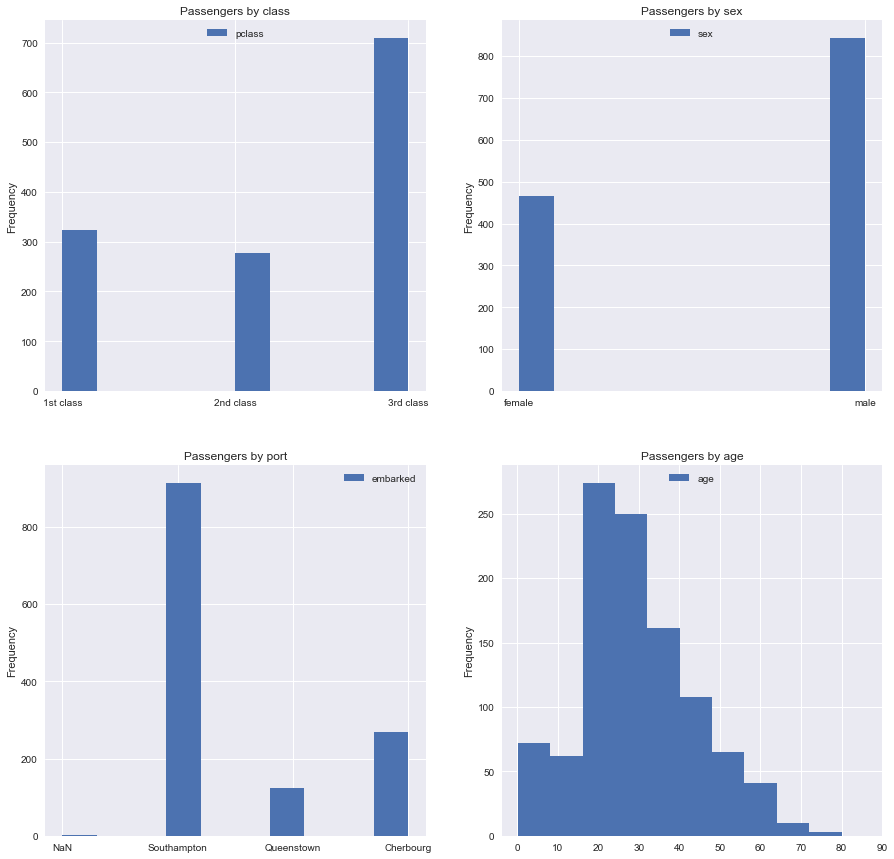

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# Travel class dataset and histogram setup
travel_class_df = pd.DataFrame(titanic_df[['pclass']])
travel_class_df.plot.hist(ax=axes[0,0])

plt.sca(axes[0, 0])
plt.title('Passengers by class')
plt.legend(loc='upper center')
plt.sca(axes[0, 0])
plt.xticks(np.arange(1.0, 4.0, 1.0), ('1st class', '2nd class', '3rd class'))


# Sex dataset and histogram setup
sex_df = pd.DataFrame(titanic_df[['sex']])
sex_df['sex'] = sex_df['sex'].apply(lambda x : 1 if x == 'male' else 0) #mapping 
sex_df.plot.hist(ax=axes[0,1])

plt.sca(axes[0, 1])
plt.title('Passengers by sex')
plt.legend(loc='upper center')
plt.xticks(np.arange(0.0, 2.0, 1.0), ('female', 'male'))


# Embarked port dataset and histogram setup
embarked_df = pd.DataFrame(titanic_df[['embarked']])
embarked_df = embarked_df.apply(lambda x: x.apply(lambda y: get_ord_from_str(y)))
embarked_df.plot.hist(ax=axes[1,0])

plt.sca(axes[1, 0])
plt.title('Passengers by port')
plt.legend(loc='upper right')
plt.xticks(np.arange(0.0, 4.0, 1.0), ('NaN', 'Southampton', 'Queenstown', 'Cherbourg'))


# Age dataset and histogram setup
age_df = pd.DataFrame(titanic_df[['age']])
age_df.plot.hist(ax=axes[1,1])

plt.sca(axes[1, 1])
plt.title('Passengers by age')
plt.legend(loc='upper center')
plt.xticks(np.arange(0.0, 100.0, 10.0))


plt.show()

### 3.3 Passengers by cabin floor
Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

In [63]:
passengers_per_cabin_floor = {}
for floor in titanic_df['cabin_floor'].unique():
    if str(floor) != 'nan':
        passengers_per_cabin_floor[int(floor)] = titanic_df[titanic_df['cabin_floor'] == floor]['cabin_floor'].count()

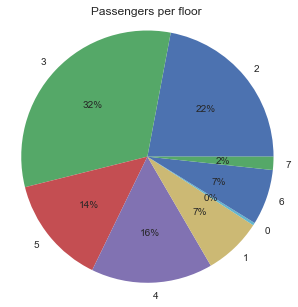

In [64]:
fig = plt.figure(figsize=(5,5))
plt.pie(list(passengers_per_cabin_floor.values()), labels=passengers_per_cabin_floor.keys(), autopct='%1.0f%%')
plt.axis('equal')
plt.title('Passengers per floor')
plt.show()

### 3.4 Survivors per class
For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

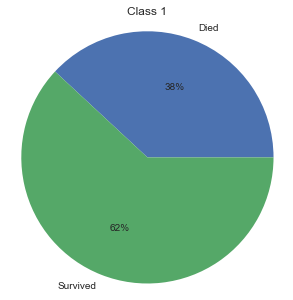

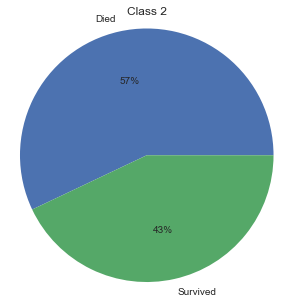

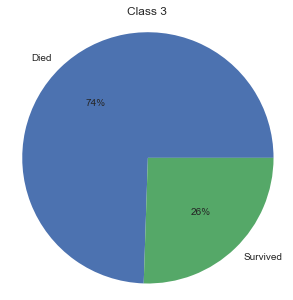

In [65]:
survivors_per_class_df = titanic_df[['pclass', 'survived']].groupby(['pclass', 'survived']).agg(len)

# Plot a pie chart for each class
for pclass in range(1,4):
    fig = plt.figure(figsize=(5,5))
    plt.pie(survivors_per_class_df[pclass], labels=['Died', 'Survived'], autopct='%1.0f%%')
    plt.axis('equal')
    plt.title('Class '+str(pclass))
    plt.show()

### 3.5 Survivors per class and sex
Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.

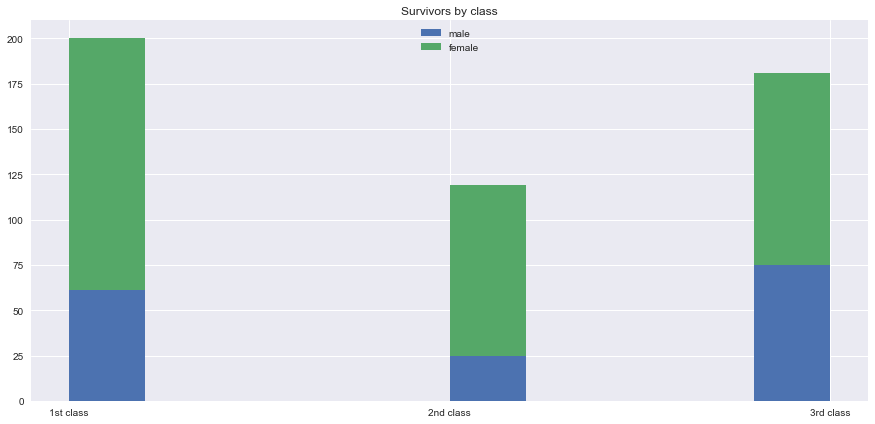

In [66]:
# Dataset for survived entries on their class and sex atributes
survivors_per_class_sex_df = pd.DataFrame(titanic_df[titanic_df.survived == 1][['pclass', 'sex']])

# Split of the data in two datasets (one for male, one for female)
male_df = survivors_per_class_sex_df[survivors_per_class_sex_df['sex'] == 'male']
female_df = survivors_per_class_sex_df[survivors_per_class_sex_df['sex'] != 'male']

# Plotting of the two datasets as stacked histogram
fig = plt.figure(figsize=(15,7))
plt.hist([male_df['pclass'], female_df['pclass']], label=['male', 'female'], stacked=True)
plt.title('Survivors by class')
plt.legend(loc='upper center')
plt.xticks(np.arange(1.0, 4.0, 1.0), ('1st class', '2nd class', '3rd class'))
plt.show()

### 3.6 Age categories
Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.

We decided to define the `age category` in the following way: we took the median age value and then grouped all the people younger in category 1 and all the older ones in category 2

In [72]:
# Define the age category
titanic_df['age_category'] = titanic_df['age'].map(lambda x: 1 if x <= titanic_df['age'].median() 
                                                                   else 2 if x > titanic_df['age'].median() 
                                                                             else None)

age_categories_df = pd.DataFrame(titanic_df[titanic_df.survived == 1][['age_category', 'pclass', 'sex']]
                                 .groupby(['age_category', 'pclass', 'sex'])
                                 .agg(len))
# Compute the proportion ratio
age_categories_df = age_categories_df.apply(lambda x : x / age_categories_df.values.sum())

# Re indexing of the table
age_categories_df.reset_index(inplace=True)

# Renaming of the datatset schema
age_categories_df.rename(columns={'age_category':'age category', 'pclass':'class', 0:'proportion'}, inplace=True)

# We set an unique, meaningful index for the dataframe
age_categories_df = age_categories_df.set_index(['age category', 'class', 'sex'])
age_categories_df

proportion
age category class sex               
1.0          1     female    0.091335
                   male      0.039813
             2     female    0.119438
                   male      0.037471
             3     female    0.131148
                   male      0.096019
2.0          1     female    0.208431
                   male      0.084309
             2     female    0.096019
                   male      0.016393
             3     female    0.037471
                   male      0.042155